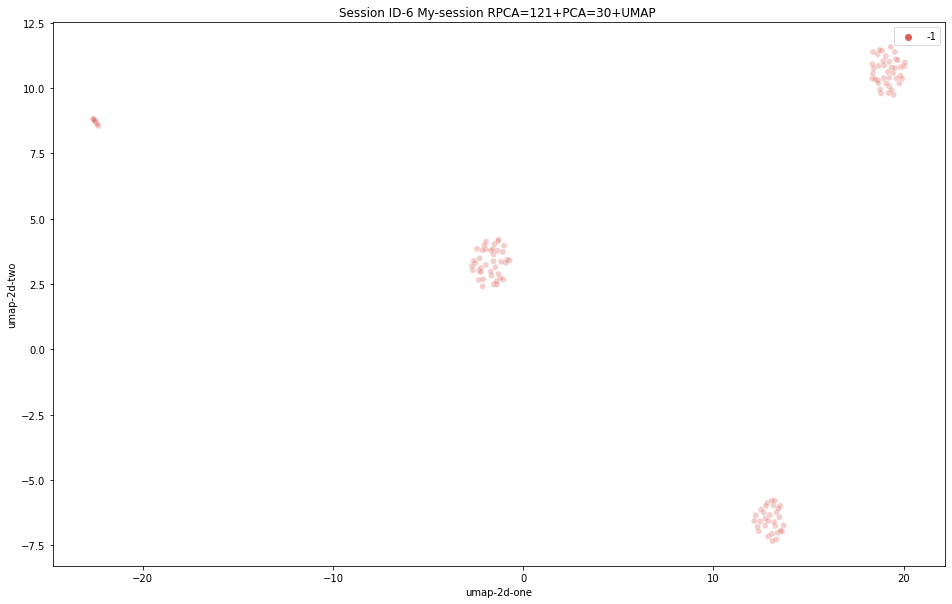

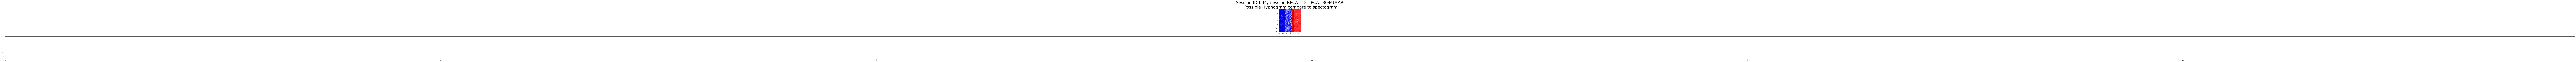

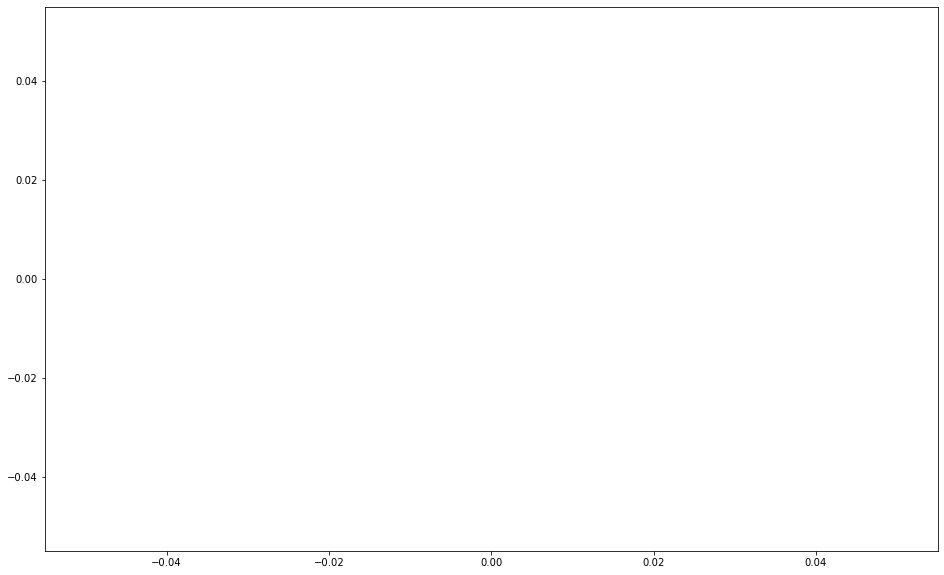

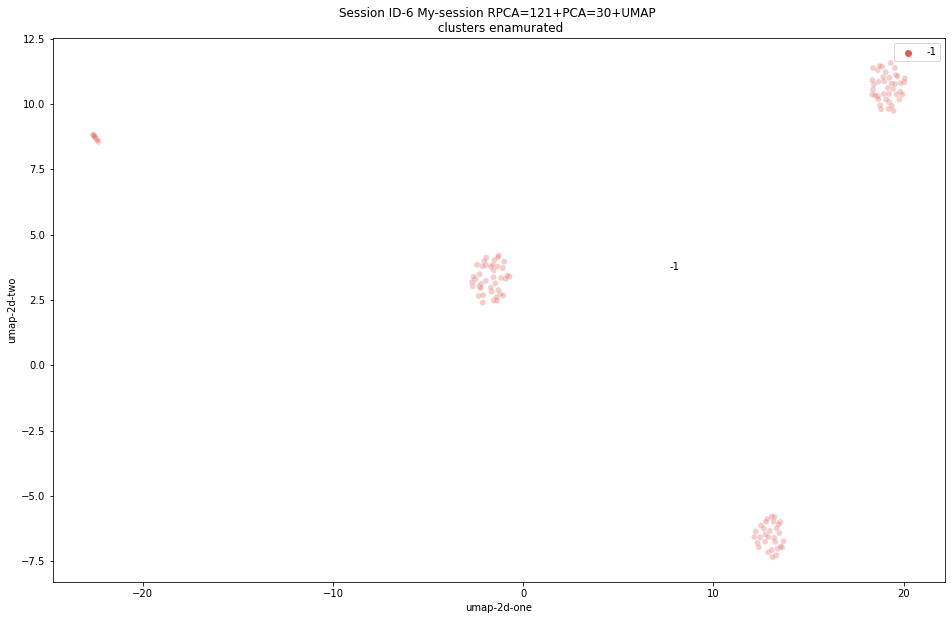

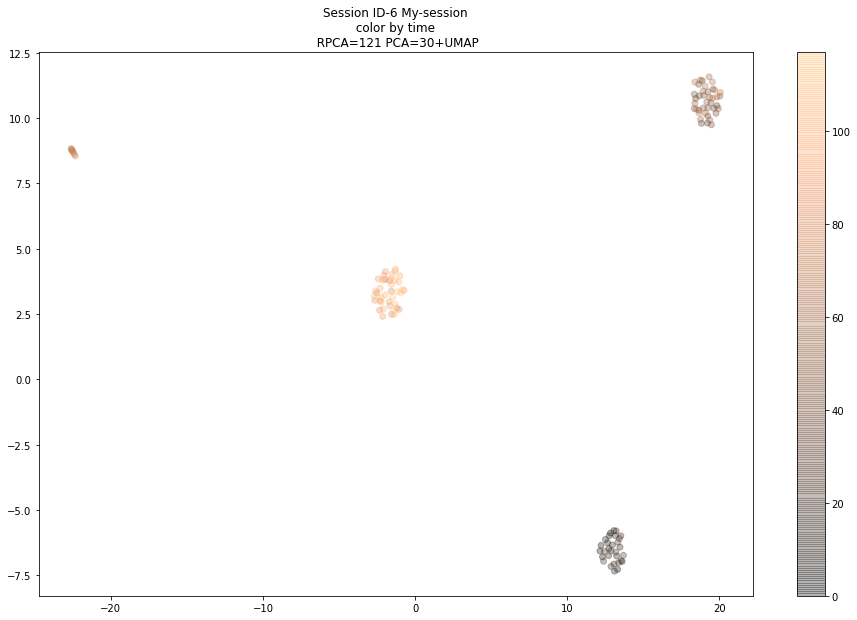

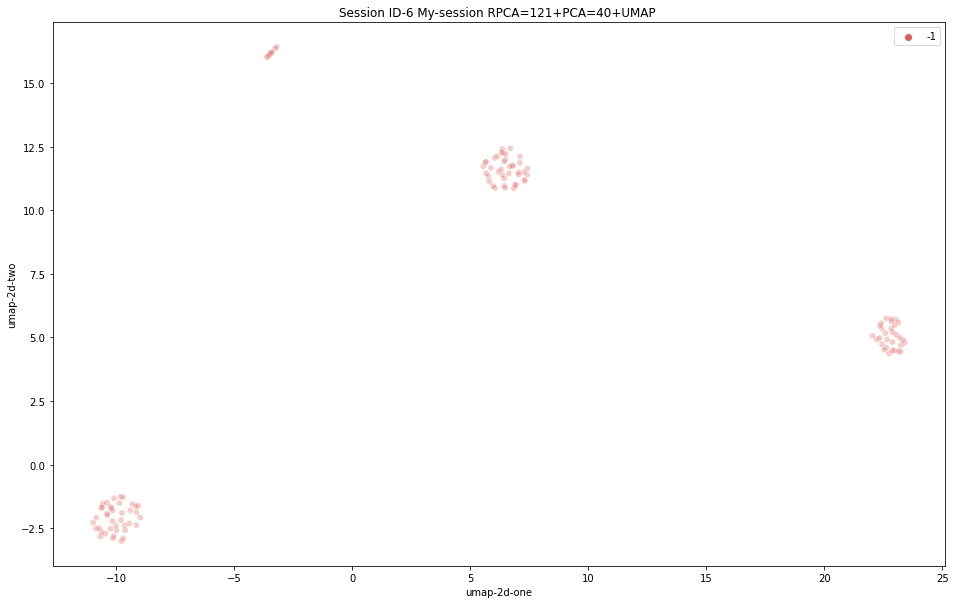

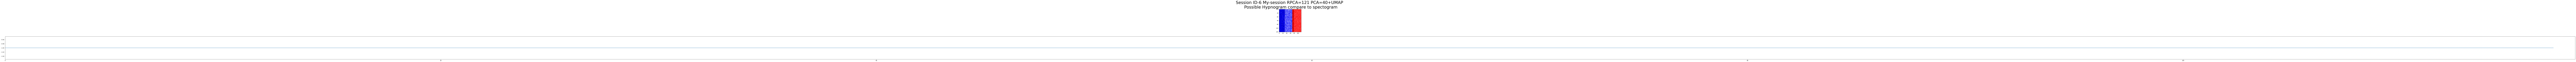

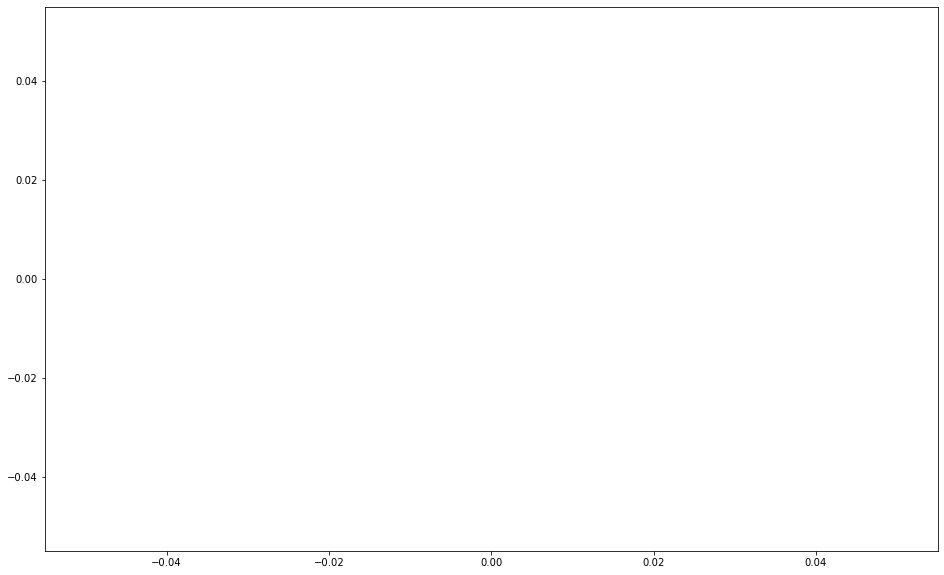

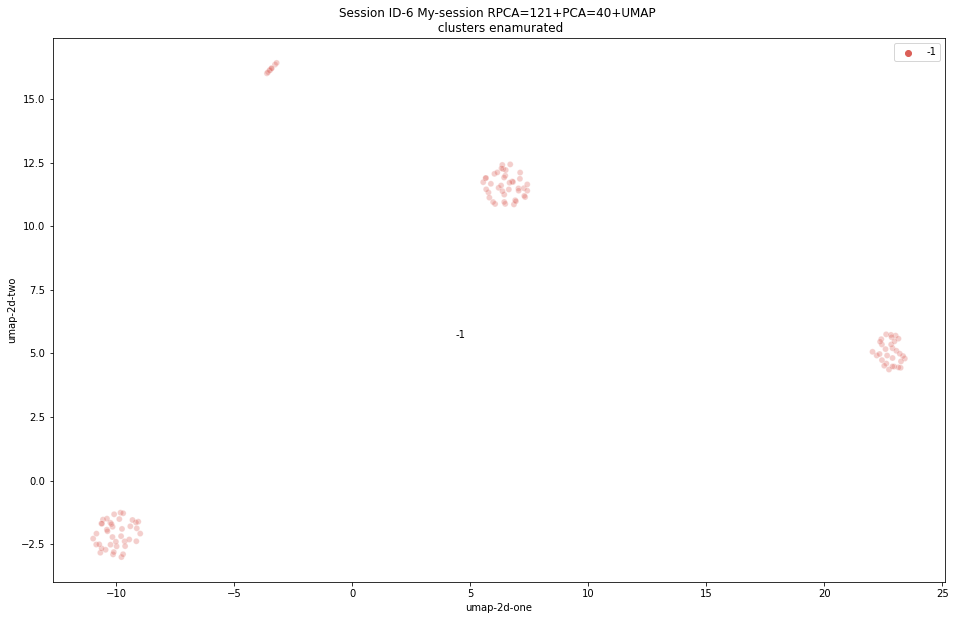

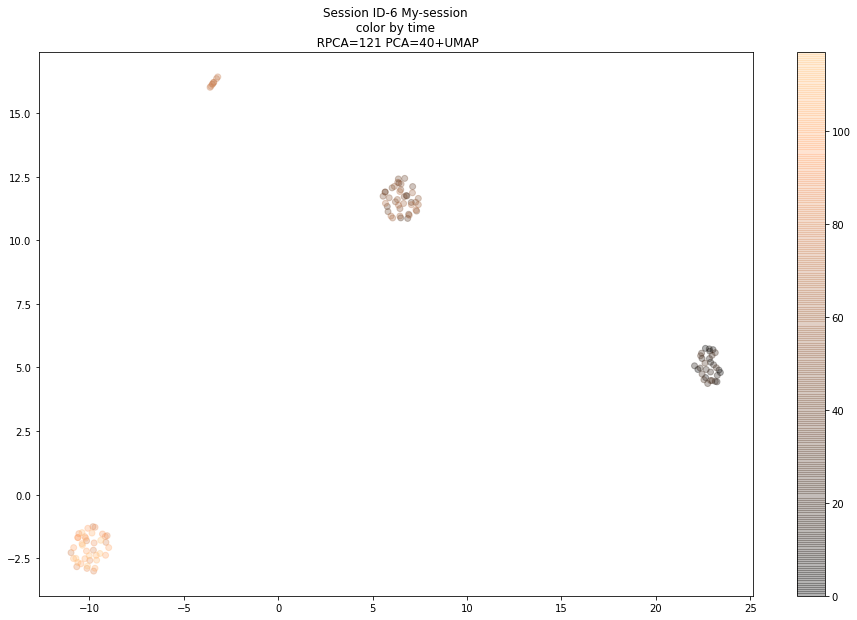

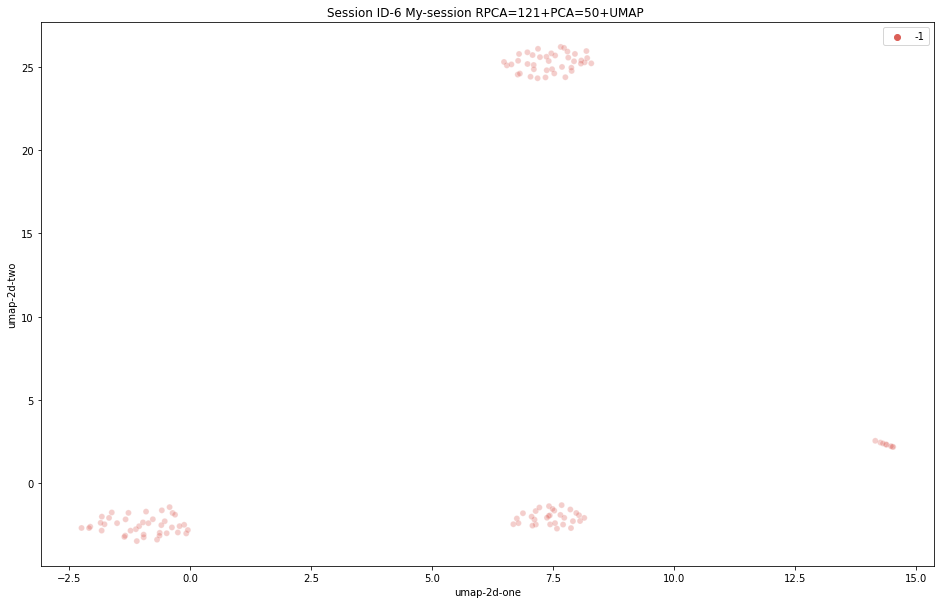

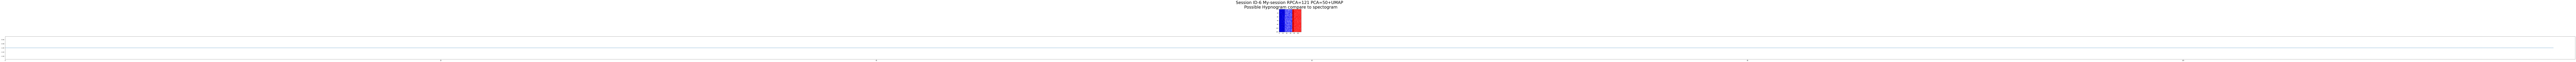

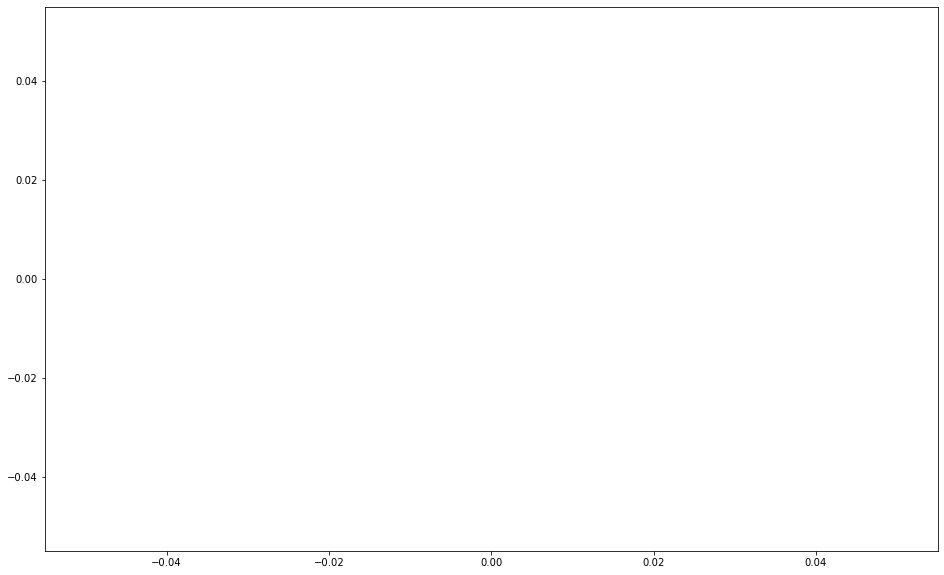

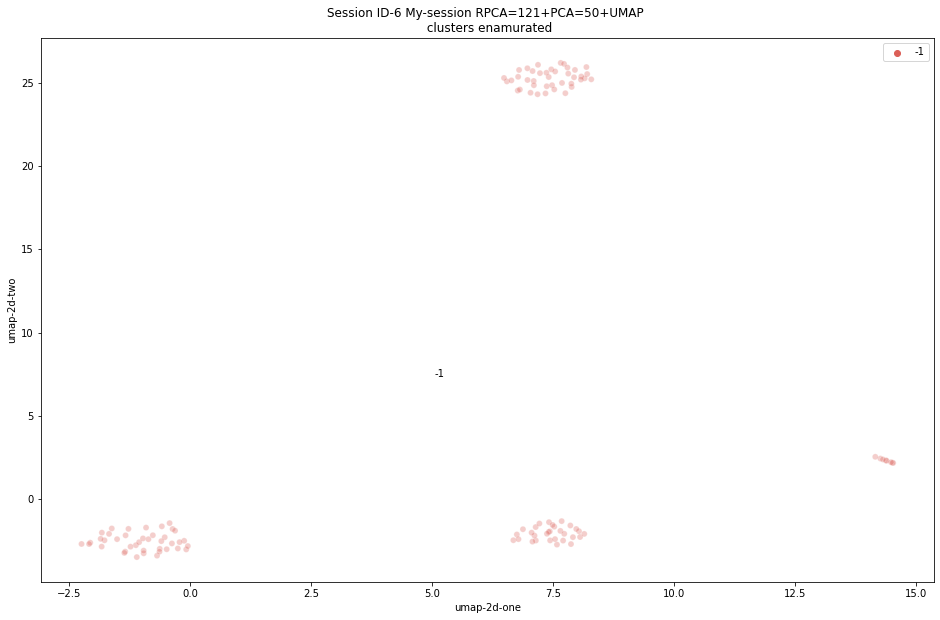

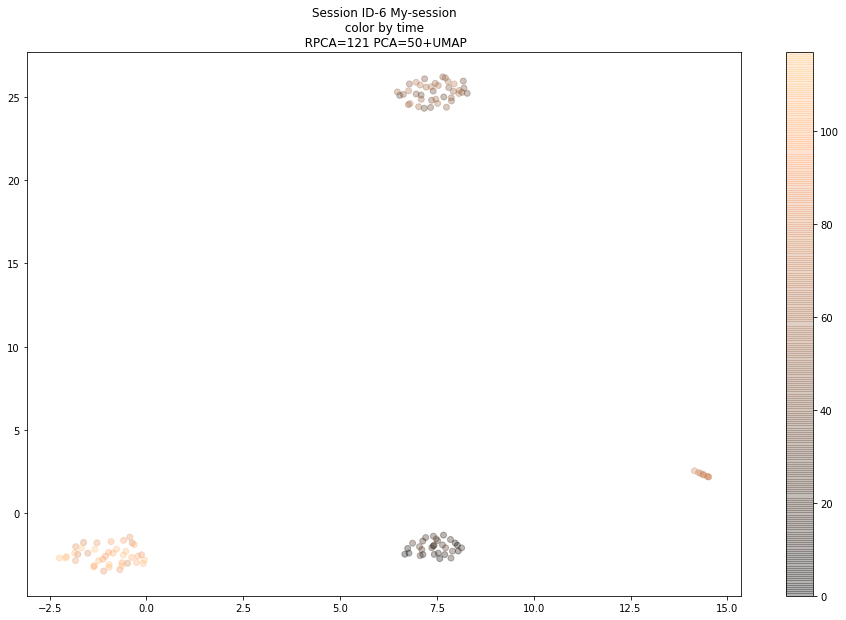

In [3]:
from importlib import reload

import sys
import mlflow

import sklearn
import umap.umap_ as umap

import os
import sys
sys.path.insert(0,os.path.join(os.getcwd(),"..\\code\\lib"))

import experiment_utils as utils

reload(utils)


samples = utils.load_data()

# set params for run
sessionName = session_name = 'My-session'

index = idx = 6
n_rpca_components = samples.shape[1]
n_pca_components = 50
n_gauss_components = 3
covariance_type = 'full'
umap_n_neighbors = 10
umap_min_dist = 0.1
umap_metric = 'euclidean'
dbscan_eps = 0.4
dbscan_min_samples = 20

for n_pca_components in [30, 40, 50]:

    # define pipe with model
    pipe = sklearn.pipeline.Pipeline(steps=[
        ('rpca', utils.skRPCA(n_components=n_rpca_components)),
        ('pca', utils.PCA(n_components=n_pca_components)),
        ('model', sklearn.mixture.GaussianMixture(n_components=n_gauss_components,
                                                  covariance_type=covariance_type))
    ])

    # fit the model and perform the inference
    model = utils.ClusterFinder(pipe)

    # train gmm and store logs
    sys.stdout = buff = utils.Buffer()
    model.fit(samples)
    sys.stdout = sys.__stdout__
    gmm_logs = {
        'iterations': [int(x.split(':')[1].split(',')[0].strip()) for x in buff.buff if x.startswith('iteration')],
        'error': [float(x.split(':')[-1].strip()) for x in buff.buff if x.startswith('iteration')]
    }

    x_pca = model.just_transforms(samples)
    reducer  = umap.UMAP(n_neighbors=umap_n_neighbors,
                         min_dist=umap_min_dist,
                         metric=umap_metric) # those are deafult params in the package
    umap_results = reducer.fit_transform(x_pca)
    clf = sklearn.cluster.DBSCAN(eps=dbscan_eps,
                                 min_samples=dbscan_min_samples)
    predicted = clf.fit_predict(umap_results)

    # plot the results
    viz = utils.Vizualization()

    # plot1
    title = ("Session ID-"
             + str(idx)
             + " "
             + sessionName
             + " RPCA="
             + str(n_rpca_components)
             + "+PCA="
             + str(n_pca_components)
             + "+UMAP ")
    viz.plot_umap(umap_results,
                  predicted,
                  title=title)

    # plot2
    title = ("Session ID-"
             + str(idx)
             + " "
             + sessionName
             + " RPCA="
             + str(n_rpca_components)
             + " PCA="
             +
             str(n_pca_components)
             + "+UMAP \n Possible Hypnogram compare to spectogram")
    fname = ("images/specto_vs_umapCluster"
             + str(idx)
             + "_RPCA="
             + str(n_rpca_components)
             + " _PCA="
             + str(n_pca_components)
             + ".png")
    viz.plot_moving_averages(samples, predicted, title=title, fname=fname)

    # plot heatmap
    # viz.plot_heatmap(umap_results, predicted)

    # plot scatter plot
    title = ("Session ID-"
             + str(idx)
             + " "
             + sessionName
             + " RPCA="+str(n_rpca_components)
             + "+PCA="+str(n_pca_components)
             + "+UMAP \n clusters enamurated")
    viz.plot_scatter(umap_results, predicted, title=title)


    # timecolor plot
    title = ("Session ID-"
             + str(idx)
             + " "
             + sessionName
             + "\n color by time \n  RPCA="
             + str(n_rpca_components)
             + " PCA="
             + str(n_pca_components)
             + "+UMAP ")
    fname = ("images/s"
             + str(idx)
             + "_RPCA="
             + str(n_rpca_components)
             + " _PCA="
             + str(n_pca_components)
             + "+UMAP_timecolor.png")
    viz.plot_timecolor(umap_results, predicted, title=title, fname=fname)


    # save logs
    gmm = pipe.steps[-1][1]
    experiment_name = 'Experiment1'
    mlflow.set_experiment(experiment_name)
    mlflow.start_run()

    # log gmm params and metrics
    mlflow.log_params({'gmm_' + k: v for k, v in gmm.get_params().items()})
    mlflow.log_params({
        'gmm_weights': gmm.weights_,
        'gmm_n_iter': gmm.n_iter_,
        'gmm_lower_bound': gmm.lower_bound_
    })

    for i in range(len(gmm_logs['iterations'])):
        mlflow.log_metrics({'error': gmm_logs['error'][i]}, step=gmm_logs['iterations'][i])


    # log the rest of the params
    mlflow.log_params({
        'n_rpca_components': n_pca_components,
        'umap_n_neighbors': umap_n_neighbors,
        'umap_min_dist': umap_min_dist,
        "umap_metric": umap_metric,
        'dbscan_eps': dbscan_eps,
        'dbscan_min_samples': dbscan_min_samples,
    })
    mlflow.end_run()


In [4]:
df = mlflow.search_runs()


In [5]:
df


run_id experiment_id    status  \
0  3610c325f009424ba60bf829a55c3bfc             1  FINISHED   
1  663a7f2d7cca42ebba2174a1cf3cb2ba             1  FINISHED   
2  f07e6908201344fa89047fe3086c28a1             1  FINISHED   

                                        artifact_uri  \
0  file:///E:/WORK/ML/Neurosteer/ML2020/notebooks...   
1  file:///E:/WORK/ML/Neurosteer/ML2020/notebooks...   
2  file:///E:/WORK/ML/Neurosteer/ML2020/notebooks...   

                        start_time                         end_time  \
0 2020-06-08 16:53:48.891000+00:00 2020-06-08 16:53:48.988000+00:00   
1 2020-06-08 16:53:12.271000+00:00 2020-06-08 16:53:12.443000+00:00   
2 2020-06-08 16:52:22.576000+00:00 2020-06-08 16:52:22.858000+00:00   

   metrics.error params.dbscan_min_samples params.gmm_reg_covar  \
0       0.000005                        20                1e-06   
1       0.000005                        20                1e-06   
2       0.000082                        20                1e-06   

  params.gmm_warm_start  ... params.gmm_verbose_interval params.umap_min_dist  \
0                 False  ...                          10                  0.1   
1                 False  ...                          10                  0.1   
2                 False  ...                          10                  0.1   

  params.gmm_precisions_init params.gmm_covariance_type params.gmm_means_init  \
0                       None                       full                  None   
1                       None                       full                  None   
2                       None                       full                  None   

  params.gmm_tol params.gmm_init_params  \
0          0.001                 kmeans   
1          0.001                 kmeans   
2          0.001                 kmeans   

                             tags.mlflow.source.name tags.mlflow.user  \
0  e:\WORK\ML\Neurosteer\neurosteer\lib\site-pack...             Hezi   
1  e:\WORK\ML\Neurosteer\neurosteer\lib\site-pack...             Hezi   
2  e:\WORK\ML\Neurosteer\neurosteer\lib\site-pack...             Hezi   

  tags.mlflow.source.type  
0                   LOCAL  
1                   LOCAL  
2                   LOCAL  

[3 rows x 33 columns]

In [ ]:
gmm_logs

In [18]:
# import mlflow

# experiment_name = 'Experiment1'
# mlflow.set_experiment(experiment_name)
# mlflow.start_run()

# # log gmm params and metrics
# mlflow.log_params({'gmm_' + k: v for k, v in gmm.get_params().items()})
# mlflow.log_params({
#     'gmm_weights': gmm.weights_,
#     'gmm_n_iter': gmm.n_iter_,
#     'gmm_lower_bound': gmm.lower_bound_
# })

# for i in range(len(gmm_logs['iterations'])):
#     mlflow.log_metrics({'error': gmm_logs['error'][i]}, step=gmm_logs['iterations'][i])


# # log the rest of the params
# mlflow.log_params({
#     'n_rpca_components': n_pca_components,
#     'umap_n_neighbors': umap_n_neighbors,
#     'umap_min_dist': umap_min_dist,
#     "umap_metric": umap_metric,
#     'dbscan_eps': dbscan_eps,
#     'dbscan_min_samples': dbscan_min_samples,
# })
# mlflow.end_run()


In [43]:
df

run_id experiment_id    status  \
0  49845c385e1f40e29f96b7d5ee18ad58             2  FINISHED   

                                        artifact_uri  \
0  file:///Users/vpushkarov/prototyping/ydata/mlr...   

                        start_time                         end_time  \
0 2020-06-05 19:13:02.762000+00:00 2020-06-05 19:43:31.902000+00:00   

   metrics.error params.gmm_reg_covar params.gmm_verbose_interval  \
0       0.000083                1e-06                          10   

  params.gmm_n_iter  ... params.gmm_init_params params.gmm_precisions_init  \
0                 2  ...                 kmeans                       None   

  params.gmm_covariance_type params.umap_metric params.umap_n_neighbors  \
0                       full          euclidean                      10   

  params.gmm_n_init params.umap_min_dist tags.mlflow.source.type  \
0                 1                  0.1                   LOCAL   

                             tags.mlflow.source.name tags.mlflow.user  
0  /Users/vpushkarov/anaconda3/envs/tf15/lib/pyth...       vpushkarov  

[1 rows x 33 columns]

In [52]:
l = list(range(9, -1, -1))
l.pop(0)
l

[8, 7, 6, 5, 4, 3, 2, 1, 0]

2 ---> 0
0 ---> 1
1 ---> 2
0 ---> 3
3 ---> 4
0 ---> 5
3 ---> 6
6 ---> 7
